In [1]:
%pip install pandas
%pip install scikit-learn
%pip install matplotlib
%pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Develop

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_log_error, mean_absolute_error


import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
data = pd.read_csv('Train.csv')

/var/folders/t2/yz2y5gb1397dsm77lnp4kz0m0000gn/T/ipykernel_69705/2592828446.py:1: DtypeWarning: Columns (1,3,4,5,6,7,8,9,10,11,12,13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('Train.csv')


In [11]:
data = data[data['id'] != 2376]

In [96]:
# feature types
numerical_features = [
    'person_capacity', 'cleanliness_rating', 'guest_satisfaction_overall',
    'bedrooms', 'dist', 'metro_dist', 'lng', 'lat'
]

categorical_features = [
    'room_type', 'day_type', 'city'
]

binary_features = [
    'room_shared', 'room_private', 'host_is_superhost', 'multi', 'biz'
]

In [98]:
for feature in binary_features:
  unique_values = data[feature].unique()
  print(f"Unique values for {feature}: {unique_values}")

# Convert 'FALSE' and 'TRUE' strings to 0 and 1, and booleans False and True to 0 and 1 for "room_shared" and "room_private"
data['room_shared'] = data['room_shared'].replace({'FALSE': 0, 'TRUE': 1, False: 0, True: 1})
data['room_private'] = data['room_private'].replace({'FALSE': 0, 'TRUE': 1, False: 0, True: 1})
data['host_is_superhost'] = data['room_private'].replace({'FALSE': 0, 'TRUE': 1, False: 0, True: 1})

# Convert '0' and '1' strings to numbers for "multi" and "biz", and leave numbers as they are
data['multi'] = data['multi'].replace({'0': 0, '1': 1}).astype(int)
data['biz'] = data['biz'].replace({'0': 0, '1': 1}).astype(int)

for feature in binary_features:
  unique_values = data[feature].unique()
  print(f"Converted unique values for {feature}: {unique_values}")

Unique values for room_shared: [0 1]
Unique values for room_private: [0 1]
Unique values for host_is_superhost: ['FALSE' 'TRUE' False True]
Unique values for multi: [0 1]
Unique values for biz: [1 0]
Converted unique values for room_shared: [0 1]
Converted unique values for room_private: [0 1]
Converted unique values for host_is_superhost: [0 1]
Converted unique values for multi: [0 1]
Converted unique values for biz: [1 0]


In [12]:
data['realSum'] = data['realSum'].astype(float).round().astype(int)

In [135]:
data['log_realSum'] = np.log1p(data['realSum'])

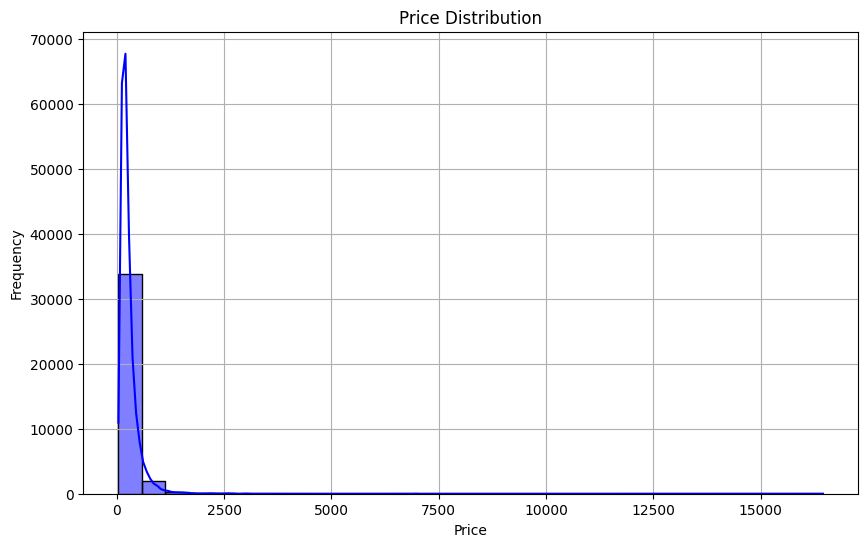

In [14]:
plt.figure(figsize=(10, 6))
sns.histplot(data['realSum'], kde=True, bins=30, color='blue')
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [68]:
price_90_percentile = np.percentile(data['realSum'], 90)
price_99_percentile = np.percentile(data['realSum'], 99)
print(f"90% percentile: {price_90_percentile}")
print(f"99% percentile: {price_99_percentile}")

90% percentile: 498.0
99% percentile: 1159.0699999999997


In [99]:
# DataFrame for everything below $500
below_90th = data[data['realSum'] < price_90_percentile]

# DataFrame for everything between $500 and $1500
between_90th_99th = data[(data['realSum'] >= price_90_percentile) & (data['realSum'] <= price_99_percentile)]

# DataFrame for everything below $1500
below_99th = data[data['realSum'] < price_99_percentile]

# DataFrame for everything above $1500
above_99th = data[data['realSum'] > price_99_percentile]

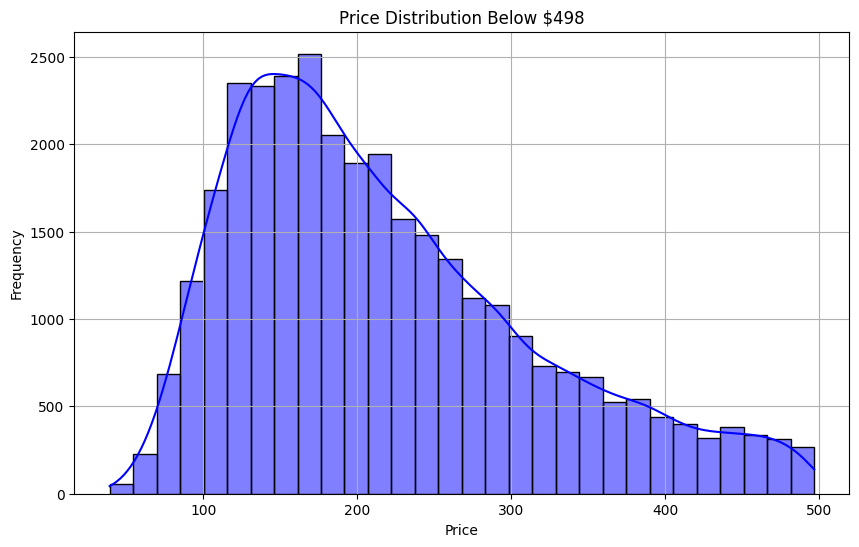

In [70]:
# Distrubution of prices below $500
plt.figure(figsize=(10, 6))
sns.histplot(below_90th['realSum'], kde=True, bins=30, color='blue')
plt.title('Price Distribution Below $498')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

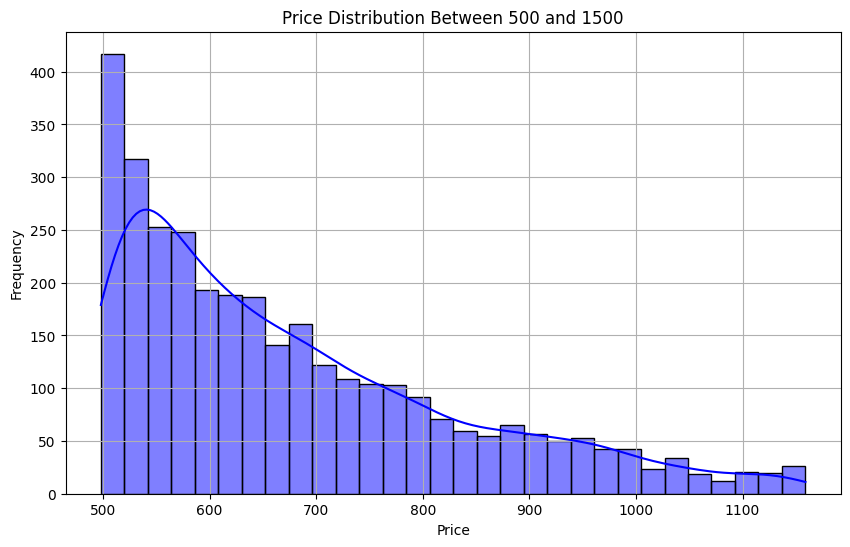

In [71]:
# Distrubution of prices between $500 and $1500
plt.figure(figsize=(10, 6))
sns.histplot(between_90th_99th['realSum'], kde=True, bins=30, color='blue')
plt.title('Price Distribution Between 500 and 1500')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

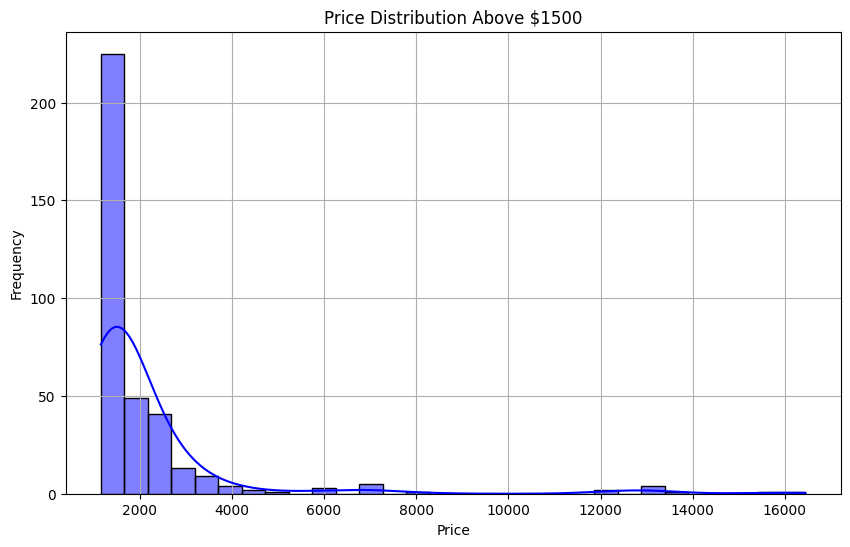

In [72]:
# Distrubution of prices between $500 and $1500
plt.figure(figsize=(10, 6))
sns.histplot(above_99th['realSum'], kde=True, bins=30, color='blue')
plt.title('Price Distribution Above $1500')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

/var/folders/t2/yz2y5gb1397dsm77lnp4kz0m0000gn/T/ipykernel_69705/2231423048.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  below_90th['log_realSum'] = np.log1p(below_90th['realSum'])


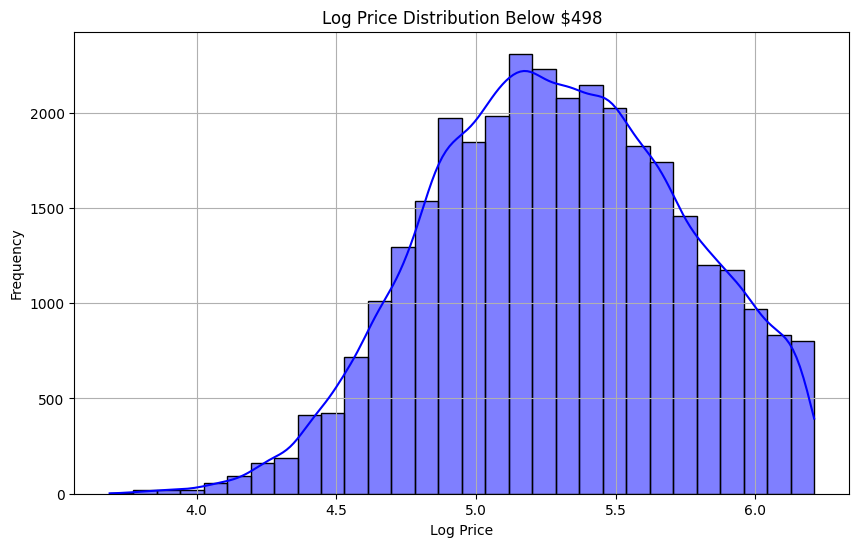

In [82]:
below_90th['log_realSum'] = np.log1p(below_90th['realSum'])

# Log distribution of prices below $500
plt.figure(figsize=(10, 6))
sns.histplot(below_90th['log_realSum'], kde=True, bins=30, color='blue')
plt.title('Log Price Distribution Below $498')
plt.xlabel('Log Price')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

/var/folders/t2/yz2y5gb1397dsm77lnp4kz0m0000gn/T/ipykernel_69705/344798964.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  between_90th_99th['log_realSum'] = np.log1p(between_90th_99th['realSum'])


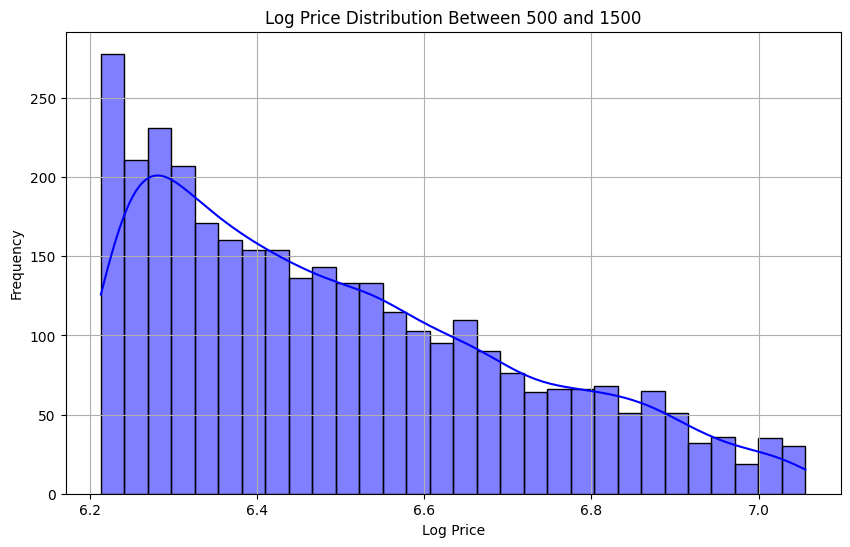

In [74]:
between_90th_99th['log_realSum'] = np.log1p(between_90th_99th['realSum'])
# Log distribution of prices between $500 and $1500
plt.figure(figsize=(10, 6))
sns.histplot(between_90th_99th['log_realSum'], kde=True, bins=30, color='blue')
plt.title('Log Price Distribution Between 500 and 1500')
plt.xlabel('Log Price')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

/var/folders/t2/yz2y5gb1397dsm77lnp4kz0m0000gn/T/ipykernel_69705/1891754782.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  below_99th['log_realSum'] = np.log1p(below_99th['realSum'])


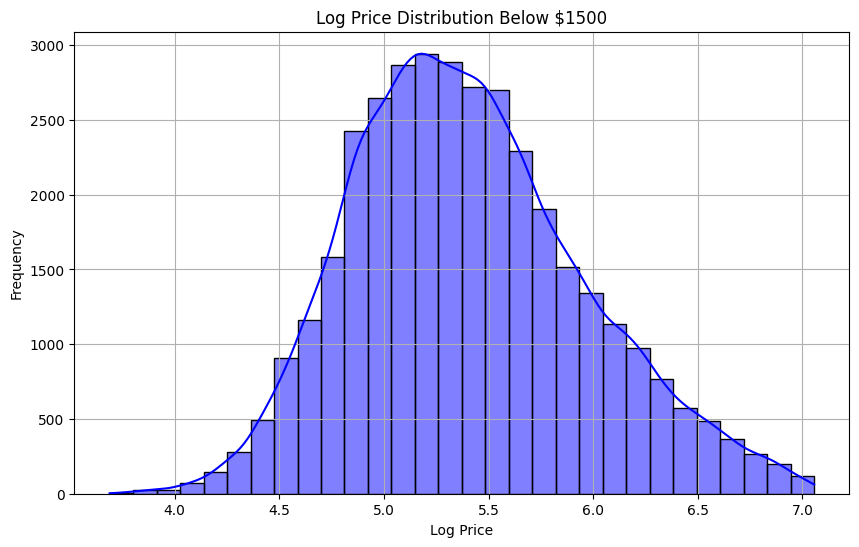

In [118]:
below_99th['log_realSum'] = np.log1p(below_99th['realSum'])
# Log distribution of prices below $1500
plt.figure(figsize=(10, 6))
sns.histplot(below_99th['log_realSum'], kde=True, bins=30, color='blue')
plt.title('Log Price Distribution Below $1500')
plt.xlabel('Log Price')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [101]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

bin_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

In [102]:
preprocessor = ColumnTransformer([
    ('num', num_pipeline, numerical_features),
    ('cat', cat_pipeline, categorical_features),
    ('bin', bin_pipeline, binary_features),
])

In [103]:
model = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', HistGradientBoostingRegressor(random_state=42))
])

In [111]:
below_90thX = below_90th[numerical_features + categorical_features + binary_features]
below_90thy = below_90th['realSum']

below_90thX_train, below_90thX_test, below_90thy_train, below_90thy_test = train_test_split(
    below_90thX, below_90thy, test_size=0.2, random_state=42
)


below_99thX = below_99th[numerical_features + categorical_features + binary_features]
below_99thy = below_99th['realSum']

below_99thX_train, below_99thX_test, below_99thy_train, below_99thy_test = train_test_split(
    below_99thX, below_99thy, test_size=0.2, random_state=42
)

In [105]:
param_grid = {
    'regressor__max_iter': [100, 200],
    'regressor__learning_rate': [0.05, 0.1],
    'regressor__max_depth': [6, 10],
    'regressor__l2_regularization': [0.0, 0.1, 1.0],
}

In [112]:
grid_search_below90th = GridSearchCV(
    model, param_grid, cv=5,
    scoring='neg_root_mean_squared_error', verbose=1, n_jobs=-1
)

grid_search_below99th = GridSearchCV(
    model, param_grid, cv=5,
    scoring='neg_root_mean_squared_error', verbose=1, n_jobs=-1
)

In [107]:
grid_search_below90th.fit(below_90thX_train, below_90thy_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['person_capacity',
                                                                          'cleanliness_rating',
                                                                          'guest_satisfaction_overall',
                                                                          'bedrooms',
                                                                          'dist',
                                                                          'metro_dist',
                                                                          'lng',
                                                                          'lat']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImput...
                                                                                          SimpleImputer(strategy='most_frequent'))]),
                                                                         ['room_shared',
                                                                          'room_private',
                                                                          'host_is_superhost',
                                                                          'multi',
                                                                          'biz'])])),
                                       ('regressor',
                                        HistGradientBoostingRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'regressor__l2_regularization': [0.0, 0.1, 1.0],
                         'regressor__learning_rate': [0.05, 0.1],
                         'regressor__max_depth': [6, 10],
                         'regressor__max_iter': [100, 200]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [114]:
grid_search_below99th.fit(below_99thX_train, below_99thy_train)
best_model_below99th = grid_search_below99th.best_estimator_

Fitting 5 folds for each of 24 candidates, totalling 120 fits


# Non Log below 90th model

In [109]:
model_below90th = grid_search_below90th.best_estimator_

y_pred_below90th = model_below90th.predict(below_90thX_test)
rmse_below90th = np.sqrt(mean_squared_log_error(below_90thy_test, y_pred_below90th)) 
mae_below90th = mean_absolute_error(below_90thy_test, y_pred_below90th)


print(f"Root Mean Squared Log Error: {rmse_below90th:.4f}")
print(f"Mean Absolute Error: {mae_below90th:.2f}")

Root Mean Squared Log Error: 0.2472
Mean Absolute Error: 40.58


In [110]:
# Prepare the features and target from the entire dataset
allX = data[numerical_features + categorical_features + binary_features]
ally = data['realSum']

# Predict using the trained model
ally_pred = model_below90th.predict(allX)

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_log_error(ally, ally_pred))
mae = mean_absolute_error(ally, ally_pred)

print(f"Root Mean Squared Log Error (Entire Data): {rmse:.4f}")
print(f"Mean Absolute Error (Entire Data): {mae:.2f}")

Root Mean Squared Log Error (Entire Data): 0.3238
Mean Absolute Error (Entire Data): 76.66


# Non log Below 99th model

In [115]:
model_below99th = grid_search_below99th.best_estimator_

y_pred_below99th = model_below90th.predict(below_99thX_test)
rmse_below99th = np.sqrt(mean_squared_log_error(below_99thy_test, y_pred_below99th)) 
mae_below99th = mean_absolute_error(below_99thy_test, y_pred_below99th)


print(f"Root Mean Squared Log Error: {rmse_below99th:.4f}")
print(f"Mean Absolute Error: {mae_below99th:.2f}")

Root Mean Squared Log Error: 0.2864
Mean Absolute Error: 61.05


In [116]:
# Predict using the trained model
ally_pred_99 = model_below99th.predict(allX)

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_log_error(ally, ally_pred_99))
mae = mean_absolute_error(ally, ally_pred_99)

print(f"Root Mean Squared Log Error (Entire Data): {rmse:.4f}")
print(f"Mean Absolute Error (Entire Data): {mae:.2f}")

Root Mean Squared Log Error (Entire Data): 0.2906
Mean Absolute Error (Entire Data): 66.16


# Log models

In [130]:
logX = below_99th[numerical_features + categorical_features + binary_features]
logy = below_99th['log_realSum']

logX_train, logX_test, logy_train, logy_test = train_test_split(
    logX, logy, test_size=0.2, random_state=42
)

In [122]:
grid_search_log = GridSearchCV(
    model, param_grid, cv=5,
    scoring='neg_root_mean_squared_error', verbose=1, n_jobs=-1
)

In [131]:
grid_search_log.fit(logX_train, logy_train)
best_model_log = grid_search_log.best_estimator_

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [137]:
y_pred_log = best_model_log.predict(logX_test)
y_pred_log = np.expm1(y_pred_log)  # convert back to real prices
y_true_log = np.expm1(logy_test)
rmse_log = np.sqrt(mean_squared_log_error(y_true_log, y_pred_log)) 
mae_log = mean_absolute_error(y_true_log, y_pred_log)

print(f"Root Mean Squared Log Error: {rmse_log:.4f}")
print(f"Mean Absolute Error: {mae_log:.2f}")

# test on all data
y_pred_log_all = best_model_log.predict(allX)
y_pred_log_all = np.expm1(y_pred_log_all)  # convert back to real prices
y_true_log_all = np.expm1(data['log_realSum'])
rmse_log_all = np.sqrt(mean_squared_log_error(y_true_log_all, y_pred_log_all))
mae_log_all = mean_absolute_error(y_true_log_all, y_pred_log_all)
print(f"Root Mean Squared Log Error (Entire Data): {rmse_log_all:.4f}")
print(f"Mean Absolute Error (Entire Data): {mae_log_all:.2f}")

Root Mean Squared Log Error: 0.2749
Mean Absolute Error: 56.30
Root Mean Squared Log Error (Entire Data): 0.2857
Mean Absolute Error (Entire Data): 66.00


In [138]:
# Prepare features and target for the entire dataset
logX_full = data[numerical_features + categorical_features + binary_features]
logy_full = data['log_realSum']

# Train the model using the entire dataset
grid_search_log_full = GridSearchCV(
  model, param_grid, cv=5,
  scoring='neg_root_mean_squared_error', verbose=1, n_jobs=-1
)

grid_search_log_full.fit(logX_full, logy_full)

# Get the best model
best_model_log_full = grid_search_log_full.best_estimator_

# Print the best parameters
print("Best parameters for log model on full dataset:", grid_search_log_full.best_params_)

# Predict using the trained model
y_pred_log_full = best_model_log_full.predict(logX_full)
y_pred_log_full = np.expm1(y_pred_log_full)  # convert back to real prices
y_true_log_full = np.expm1(data['log_realSum'])
rmse_log_full = np.sqrt(mean_squared_log_error(y_true_log_full, y_pred_log_full))
mae_log_full = mean_absolute_error(y_true_log_full, y_pred_log_full)

print(f"Root Mean Squared Log Error (Entire Data): {rmse_log_full:.4f}")
print(f"Mean Absolute Error (Entire Data): {mae_log_full:.2f}")

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters for log model on full dataset: {'regressor__l2_regularization': 0.0, 'regressor__learning_rate': 0.1, 'regressor__max_depth': 10, 'regressor__max_iter': 200}
Root Mean Squared Log Error (Entire Data): 0.2724
Mean Absolute Error (Entire Data): 63.83
